In [96]:
import networkx as nx
import pandas as pd
from functools import reduce
import numpy as np
from enum import Enum

edge_df = pd.read_csv('../data/ahrefs/filtered_backlinks.csv')
edge_df = edge_df.groupby(['domain_from', 'domain_to'])
edge_df = edge_df.max()
edge_df.reset_index(inplace=True)
edge_df['log_links'] = np.log(edge_df['links'])

node_mapping = {k: v for v, k in enumerate(set(list(edge_df.domain_from.unique()) + list(edge_df.domain_to.unique())))}

edge_df['domain_from_idx'] = edge_df.domain_from.map(node_mapping)
edge_df['domain_to_idx'] = edge_df.domain_to.map(node_mapping)

G = nx.from_pandas_edgelist(edge_df, source='domain_from_idx', target='domain_to_idx', edge_attr=['links', 'unique_pages'], create_using=nx.DiGraph())
schemes = pd.read_csv('schemes.csv')['url'].to_list()
media_df = pd.read_csv('../data/ahrefs/filtered_attrs.csv') #[['url','label','backlinks','refpages']]

# # Iterate over df rows and set the source and target nodes' attributes for each row:
# can use this to get domain ratings from domain_to_rating column
# for index, row in node_df.iterrows():
#     G.nodes[row['url']]['backlinks'] = row['backlinks']
#     G.nodes[row['url']]['refpages'] = row['refpages']

In [97]:
from sklearn import neighbors

centralities = False
if centralities:
    def alpha(n):
        return 1/np.max([np.real(x) for x in nx.adjacency_spectrum(n, weight='log_links')])
    print('PG')
    pagerank_centrality = nx.pagerank(G, weight='log_links')
    # print('KT')
    # katz_centrality = nx.katz_centrality(G, weight='log_links', alpha=alpha(G))
    print('CL')
    closeness_centrality = nx.closeness_centrality(G, distance=1, wf_improved=False)
    print('HM')
    harmonic_centrality = nx.harmonic_centrality(G, distance=1)
    print('BT')
    betweeness_centrality = nx.betweenness_centrality(G, weight='log_links')
    print('DG')
    degree_centrality = nx.degree_centrality(G)#,  weight='log_links')
    degree_centrality = nx.degree_centrality(G)#,  weight='log_links')

def isBlogping(url):
    blogs = ['blogspot', 'e-monsite', 'wordpress', 'blogger']
    return any([blog in url for blog in blogs])

target_urls = list(edge_df.domain_to.unique())
blogping_data = []
inv_node_mapping = {v: k for k, v in node_mapping.items()}

link_scheme_dist = {1:[], 3:[], 4:[], 5:[], 6:[]}
normal_backlinker_dist = {1:[], 3:[], 4:[], 5:[], 6:[]}
normal_backlinkers = []

link_scheme_pp = {1:0, 3:0, 4:0, 5:0, 6:0}
normal_backlinker_pp = {1:0, 3:0, 4:0, 5:0, 6:0}

backlink_attrs_df = pd.read_csv('../data/ahrefs/filtered_combined_attrs.csv') #[['url','label','backlinks','refpages']]

backlink_dists = {}

for news_url in target_urls:
    current_node = node_mapping[news_url]
    preds = G.predecessors(current_node)
    count = 0
    bl_total = 0
    page_total = 0
    try:
        label = media_df[media_df['url'] == news_url]['label'].values[0]
    except:
        print(news_url)
        
    for neighbor in list(preds):
        neighbor_url = inv_node_mapping[neighbor]
        edge_data = G.get_edge_data(neighbor, current_node)
        if isBlogping(neighbor_url):
            count += 1
            bl_total += edge_data['links']
            page_total += edge_data['unique_pages']
        try:
            # total_backlinker_links = backlink_attrs_df[backlink_attrs_df['url']==neighbor_url]['links_external'].values[0]
            num_outlinks = 0
            if not neighbor_url in backlink_dists:
                total_links_observed = 0
                # print(inv_node_mapping[neighbor], news_url, edge_data['links'])
                for successor in G.successors(neighbor):
                    # if inv_node_mapping[successor] in media_df['url'].values:
                    total_links_observed += G.get_edge_data(neighbor, successor)['links']
                    num_outlinks += 1
                    # print(inv_node_mapping[successor], G.get_edge_data(neighbor, successor)['links'])
                # print(total_links_observed)
                backlink_dists[neighbor_url] = {1:0, 3:0, 4:0, 5:0, 6:0, 7:total_links_observed}
            
            total_links_observed = backlink_dists[neighbor_url][7]
            backlink_dists[neighbor_url][label] += edge_data['links']/total_links_observed

            if total_links_observed > 50000 and num_outlinks > 3:
                if neighbor_url in schemes:
                    link_scheme_pp[label] += edge_data['links']
                    link_scheme_dist[label].append(edge_data['links']/total_links_observed)
                elif not isBlogping(neighbor_url):
                    normal_backlinker_pp[label] += edge_data['links']
                    normal_backlinker_dist[label].append(edge_data['links']/total_links_observed)
                    normal_backlinkers.append(neighbor_url)
        except Exception as e:
            print(neighbor_url, e)

    if centralities:
        blogping_data.append({
            'url': news_url,
            'blogspot_backlinks': bl_total,
            'blogspot_refpages': page_total,
            'blogspot_count': count,
            'pagerank_centrality': pagerank_centrality[current_node],
            # 'katz_centrality': katz_centrality[current_node],
            'closeness_centrality': closeness_centrality[current_node],
            'harmonic_centrality': harmonic_centrality[current_node],
            'betweeness_centrality': betweeness_centrality[current_node],
            'degree_centrality': degree_centrality[current_node],
        })
    else:
        blogping_data.append({
            'url': news_url,
            'blogspot_backlinks': bl_total,
            'blogspot_refpages': page_total,
            'blogspot_count': count,
        })

blogping_df = pd.DataFrame(blogping_data)

stillnessinthestorm.com
freerepublic.com
democraticunderground.com
attitude.co.uk
thepoliticalinsider.com
truthuncensored.net
independentminute.com
nation.com.pk


In [100]:
normal_backlinker_pp[3] = normal_backlinker_pp[3] + normal_backlinker_pp[1]
link_scheme_pp[3] = link_scheme_pp[3] + link_scheme_pp[1]
normal_backlinker_pp[5] = normal_backlinker_pp[5] + normal_backlinker_pp[6]
link_scheme_pp[5] = link_scheme_pp[5] + link_scheme_pp[6]
del normal_backlinker_pp[6]
del normal_backlinker_pp[1]
del link_scheme_pp[1]
del link_scheme_pp[6]


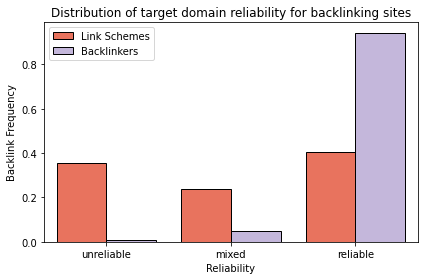

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming link_scheme_pp and normal_backlinker_pp are your dictionaries
# Calculate proportions
total_ls = sum(link_scheme_pp.values())
total_nb = sum(normal_backlinker_pp.values())


ls_proportions = [count / total_ls for count in link_scheme_pp.values()]
nb_proportions = [count / total_nb for count in normal_backlinker_pp.values()]

# Create DataFrame
data = {
    'Reliability': ['unreliable', 'mixed', 'reliable'],
    'Link Schemes': ls_proportions,
    'Backlinkers': nb_proportions
}
df = pd.DataFrame(data)

# Melt DataFrame
df_melted = df.melt(id_vars='Reliability', var_name='Type', value_name='Frequency')

# Plot with Seaborn
# plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Reliability', y='Frequency', hue='Type', palette=['tomato', '#C3B1E1'], linewidth=1, edgecolor='black')
sns.barplot(data=df_melted, x='Reliability', y='Frequency', hue='Type', palette=['tomato', '#C3B1E1'], linewidth=1, edgecolor='black')
['#da291c','purple','#003da5']
# Customize plot
plt.xlabel('Reliability')
plt.ylabel('Backlink Frequency')
plt.title('Distribution of target domain reliability for backlinking sites')
# plt.xticks(rotation=)  # Rotate x-axis labels for better readability
plt.legend(title=None)
plt.tight_layout()

# Save plot
plt.savefig('../results/link_scheme_distribution.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()